In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import h5py
import numpy as np
import pandas as pd
import logging
import re

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.8, style="whitegrid")

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(format='[%(asctime)s - %(name)s] %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG,
                        handlers=[logging.StreamHandler()])

# Import run settings

In [3]:
def import_gdrive_sheet(gdrive_key, sheet_id):
    run_spreadsheet = pd.read_csv("https://docs.google.com/spreadsheet/ccc?key=" + \
                                  gdrive_key + "&output=csv&gid=" + sheet_id)
    if "date" in run_spreadsheet.columns:
        run_spreadsheet["date"] = run_spreadsheet["date"].astype(str)
    return run_spreadsheet

gdrive_key = "gsheet_id_here"
sheet_id = "0"
set_sheet_id = "512509543"

run_spreadsheet = import_gdrive_sheet(gdrive_key, sheet_id)
set_spreadsheet = import_gdrive_sheet(gdrive_key, set_sheet_id)

In [4]:
# date = "20190830"
run_name = "10_11_19_run_02"
molbit_file = "../porcupine_sequences.fa"
run_data = dict(run_spreadsheet[run_spreadsheet["run_name"] == run_name].iloc[0, :])

In [5]:
fastq_dir = os.path.join(run_data["basecall_dir"], "pass")

# Run sequence alignment

In [6]:
def read_fasta(fasta_fname):
    '''Assumes 1 line per sequence.'''
    seqs = []
    names = []
    with open(fasta_fname) as fa:
        for line in fa:
            line = line.strip()
            if line.startswith(">"):
                names.append(line.replace(">", "").split()[0])
            else:
                seqs.append(line)
    return seqs, names

In [7]:
def read_fastq(fastq_fname):
    seqs = []
    with open(fastq_fname) as fq:
        fq = fq.readlines()
        for line_i in range(0, len(fq), 4):
            line = fq[line_i].strip().split(" ")
            read_id = str(line[0])[1:]
            seq = fq[line_i + 1].strip()
            seqs.append((read_id, seq))
    return seqs

In [8]:
from pore_utils import smith_waterman as s_w

In [9]:
def helper_run_sw(read, molbit_seqs=None, search_len=100,
                  cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    read_id, seq = read

    sw_search_end = min(len(seq), search_len)
    search_seq = seq[:sw_search_end]

    results = [read_id]
    for header_i, header_seq in enumerate(molbit_seqs):
        _, sw_score, _, sw_loc, _ = s_w.s_w(search_seq, header_seq,
                                        cost_fn=cost_fn)
        results.append(sw_score)
    return results


def run_sw(fastq_dir, out_dir, search_len=80, molbit_fa=None, n_workers=20,
           cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    os.makedirs(out_dir)
    import dask.bag as db
    from dask.diagnostics import ProgressBar
    ProgressBar().register()
    
    logger.info("Getting molbit sequences.")
    assert molbit_fa is not None
    assert os.path.exists(molbit_fa)
    molbit_seqs, molbit_names = read_fasta(molbit_fa)
    
    logger.info("Locating fastq files.")
    fastq_files = []
    for fname in os.listdir(fastq_dir):
        if fname.endswith(".fastq"):
            fastq_files.append(os.path.join(fastq_dir, fname))
    assert len(fastq_files) > 0
    
    logger.info("Running SW, one fastq at a time.")
    for fq_i, fq_fname in enumerate(fastq_files):
        logger.info(f"Starting fastq ({fq_i} of {len(fastq_files)})\n\t{fq_fname}")
        fq_seqs = read_fastq(fq_fname)
        
        bag = db.from_sequence(fq_seqs)
        dask_map = bag.map(helper_run_sw, molbit_seqs=molbit_seqs,
                           search_len=search_len, cost_fn=cost_fn)
        sw_scores = dask_map.compute(num_workers=n_workers)
        
        cols = ["read_id"] + [f"sw_score_molbit_{molbit}" for molbit in molbit_names]
        sw_df = pd.DataFrame(sw_scores, columns=cols)
        sw_df.index = sw_df["read_id"]
        del sw_df["read_id"]
        out_fname = fq_fname.split("/")[-1].replace(".fastq", "") + ".tsv"
        out_fname = os.path.join(out_dir, out_fname)
        logger.info(f"Saving to file: {out_fname}")
        sw_df.to_csv(out_fname, sep="\t", index=True)

In [10]:
sw_dir = os.path.join(run_data["basecall_dir"], "sw")
cost_fn = {"match": 1, "mismatch": -1, "gap": -8}

In [11]:
run_sw(fastq_dir, sw_dir, search_len=80, cost_fn=cost_fn, molbit_fa=molbit_file, n_workers=40)

[10:26:56 - __main__] Getting molbit sequences.
[10:26:56 - __main__] Locating fastq files.
[10:26:56 - __main__] Running SW, one fastq at a time.
[10:26:56 - __main__] Starting fastq (0 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_0_0.fastq


[########################################] | 100% Completed |  0.9s


[10:26:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_0_0.tsv
[10:26:57 - __main__] Starting fastq (1 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_0_1.fastq


[########################################] | 100% Completed |  0.8s


[10:26:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_0_1.tsv
[10:26:58 - __main__] Starting fastq (2 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_1_0.fastq


[########################################] | 100% Completed | 56.7s


[10:27:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_1_0.tsv
[10:27:55 - __main__] Starting fastq (3 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_1_1.fastq


[########################################] | 100% Completed | 37.7s


[10:28:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_1_1.tsv
[10:28:33 - __main__] Starting fastq (4 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_1_2.fastq


[########################################] | 100% Completed | 28.1s


[10:29:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_1_2.tsv
[10:29:01 - __main__] Starting fastq (5 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_1_3.fastq


[########################################] | 100% Completed | 52.6s


[10:29:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_1_3.tsv
[10:29:55 - __main__] Starting fastq (6 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_2_0.fastq


[########################################] | 100% Completed |  1min 44.0s


[10:31:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_2_0.tsv
[10:31:39 - __main__] Starting fastq (7 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_2_1.fastq


[########################################] | 100% Completed |  1min 44.1s


[10:33:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_2_1.tsv
[10:33:24 - __main__] Starting fastq (8 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_2_2.fastq


[########################################] | 100% Completed | 59.7s


[10:34:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_2_2.tsv
[10:34:24 - __main__] Starting fastq (9 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_3_0.fastq


[########################################] | 100% Completed |  1min 36.7s


[10:36:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_3_0.tsv
[10:36:01 - __main__] Starting fastq (10 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_3_1.fastq


[########################################] | 100% Completed |  1min  0.5s


[10:37:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_3_1.tsv
[10:37:02 - __main__] Starting fastq (11 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_3_2.fastq


[########################################] | 100% Completed |  1min 54.0s


[10:38:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_3_2.tsv
[10:38:57 - __main__] Starting fastq (12 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_2_3.fastq


[########################################] | 100% Completed | 58.3s


[10:39:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_2_3.tsv
[10:39:56 - __main__] Starting fastq (13 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_3_3.fastq


[########################################] | 100% Completed | 32.3s


[10:40:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_3_3.tsv
[10:40:29 - __main__] Starting fastq (14 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_4_0.fastq


[########################################] | 100% Completed |  3min 21.4s


[10:43:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_4_0.tsv
[10:43:51 - __main__] Starting fastq (15 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_4_1.fastq


[########################################] | 100% Completed |  1min 40.9s


[10:45:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_4_1.tsv
[10:45:32 - __main__] Starting fastq (16 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_4_2.fastq


[########################################] | 100% Completed | 24.1s


[10:45:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_4_2.tsv
[10:45:57 - __main__] Starting fastq (17 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_4_3.fastq


[########################################] | 100% Completed | 26.5s


[10:46:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_4_3.tsv
[10:46:24 - __main__] Starting fastq (18 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_5_0.fastq


[########################################] | 100% Completed |  1min 47.1s


[10:48:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_5_0.tsv
[10:48:12 - __main__] Starting fastq (19 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_5_1.fastq


[########################################] | 100% Completed |  1min 39.0s


[10:49:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_5_1.tsv
[10:49:51 - __main__] Starting fastq (20 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_5_2.fastq


[########################################] | 100% Completed |  1min 21.3s


[10:51:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_5_2.tsv
[10:51:13 - __main__] Starting fastq (21 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_6_0.fastq


[########################################] | 100% Completed |  1min 45.1s


[10:52:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_6_0.tsv
[10:52:59 - __main__] Starting fastq (22 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_6_1.fastq


[########################################] | 100% Completed |  1min 20.8s


[10:54:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_6_1.tsv
[10:54:20 - __main__] Starting fastq (23 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_6_2.fastq


[########################################] | 100% Completed |  1min 14.9s


[10:55:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_6_2.tsv
[10:55:36 - __main__] Starting fastq (24 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_6_3.fastq


[########################################] | 100% Completed | 28.7s


[10:56:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_6_3.tsv
[10:56:05 - __main__] Starting fastq (25 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_7_0.fastq


[########################################] | 100% Completed |  8.7s


[10:56:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_7_0.tsv
[10:56:14 - __main__] Starting fastq (26 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_8_0.fastq


[########################################] | 100% Completed |  1min  4.2s


[10:57:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_8_0.tsv
[10:57:19 - __main__] Starting fastq (27 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_8_1.fastq


[########################################] | 100% Completed |  1min 28.2s


[10:58:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_8_1.tsv
[10:58:48 - __main__] Starting fastq (28 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_5_3.fastq


[########################################] | 100% Completed |  1.7s


[10:58:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_5_3.tsv
[10:58:49 - __main__] Starting fastq (29 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_8_2.fastq


[########################################] | 100% Completed |  1min 58.7s


[11:00:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_8_2.tsv
[11:00:49 - __main__] Starting fastq (30 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_8_3.fastq


[########################################] | 100% Completed |  8.2s


[11:00:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_8_3.tsv
[11:00:57 - __main__] Starting fastq (31 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_9_0.fastq


[########################################] | 100% Completed |  2.6s


[11:01:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_9_0.tsv
[11:01:00 - __main__] Starting fastq (32 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_10_0.fastq


[########################################] | 100% Completed |  1min 53.8s


[11:02:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_10_0.tsv
[11:02:55 - __main__] Starting fastq (33 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_9_1.fastq


[########################################] | 100% Completed |  2min 23.1s


[11:05:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_9_1.tsv
[11:05:18 - __main__] Starting fastq (34 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_9_2.fastq


[########################################] | 100% Completed |  8.7s


[11:05:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_9_2.tsv
[11:05:28 - __main__] Starting fastq (35 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_10_1.fastq


[########################################] | 100% Completed | 56.5s


[11:06:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_10_1.tsv
[11:06:25 - __main__] Starting fastq (36 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_11_0.fastq


[########################################] | 100% Completed |  3min 23.7s


[11:09:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_11_0.tsv
[11:09:49 - __main__] Starting fastq (37 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_10_2.fastq


[########################################] | 100% Completed |  1min 45.0s


[11:11:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_10_2.tsv
[11:11:34 - __main__] Starting fastq (38 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_11_1.fastq


[########################################] | 100% Completed | 55.4s


[11:12:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_11_1.tsv
[11:12:30 - __main__] Starting fastq (39 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_9_3.fastq


[########################################] | 100% Completed |  2min 17.9s


[11:14:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_9_3.tsv
[11:14:49 - __main__] Starting fastq (40 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_11_2.fastq


[########################################] | 100% Completed |  2.0s


[11:14:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_11_2.tsv
[11:14:51 - __main__] Starting fastq (41 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_12_0.fastq


[########################################] | 100% Completed |  1min 36.1s


[11:16:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_12_0.tsv
[11:16:28 - __main__] Starting fastq (42 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_12_1.fastq


[########################################] | 100% Completed |  1min 23.2s


[11:17:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_12_1.tsv
[11:17:52 - __main__] Starting fastq (43 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_12_2.fastq


[########################################] | 100% Completed |  1min 15.0s


[11:19:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_12_2.tsv
[11:19:07 - __main__] Starting fastq (44 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_13_0.fastq


[########################################] | 100% Completed |  1min 20.6s


[11:20:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_13_0.tsv
[11:20:28 - __main__] Starting fastq (45 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_13_1.fastq


[########################################] | 100% Completed |  2min 27.6s


[11:22:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_13_1.tsv
[11:22:56 - __main__] Starting fastq (46 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_10_3.fastq


[########################################] | 100% Completed |  1.8s


[11:22:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_10_3.tsv
[11:22:59 - __main__] Starting fastq (47 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_11_3.fastq


[########################################] | 100% Completed |  1.8s


[11:23:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_11_3.tsv
[11:23:01 - __main__] Starting fastq (48 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_12_3.fastq


[########################################] | 100% Completed |  1.9s


[11:23:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_12_3.tsv
[11:23:03 - __main__] Starting fastq (49 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_13_2.fastq


[########################################] | 100% Completed |  1.9s


[11:23:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_13_2.tsv
[11:23:05 - __main__] Starting fastq (50 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_14_0.fastq


[########################################] | 100% Completed |  2min 28.7s


[11:25:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_14_0.tsv
[11:25:35 - __main__] Starting fastq (51 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_13_3.fastq


[########################################] | 100% Completed |  1min 39.3s


[11:27:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_13_3.tsv
[11:27:14 - __main__] Starting fastq (52 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_14_1.fastq


[########################################] | 100% Completed |  1min  8.3s


[11:28:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_14_1.tsv
[11:28:23 - __main__] Starting fastq (53 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_14_2.fastq


[########################################] | 100% Completed | 27.2s


[11:28:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_14_2.tsv
[11:28:51 - __main__] Starting fastq (54 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_14_3.fastq


[########################################] | 100% Completed | 33.3s


[11:29:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_14_3.tsv
[11:29:25 - __main__] Starting fastq (55 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_15_0.fastq


[########################################] | 100% Completed |  1min 15.8s


[11:30:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_15_0.tsv
[11:30:41 - __main__] Starting fastq (56 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_15_1.fastq


[########################################] | 100% Completed |  1min 51.6s


[11:32:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_15_1.tsv
[11:32:33 - __main__] Starting fastq (57 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_15_2.fastq


[########################################] | 100% Completed | 50.2s


[11:33:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_15_2.tsv
[11:33:24 - __main__] Starting fastq (58 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_15_3.fastq


[########################################] | 100% Completed | 32.4s


[11:33:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_15_3.tsv
[11:33:57 - __main__] Starting fastq (59 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_16_0.fastq


[########################################] | 100% Completed | 43.8s


[11:34:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_16_0.tsv
[11:34:41 - __main__] Starting fastq (60 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_16_1.fastq


[########################################] | 100% Completed |  2min 50.1s


[11:37:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_16_1.tsv
[11:37:32 - __main__] Starting fastq (61 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_16_2.fastq


[########################################] | 100% Completed |  1min 56.1s


[11:39:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_16_2.tsv
[11:39:29 - __main__] Starting fastq (62 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_17_0.fastq


[########################################] | 100% Completed |  2min 46.8s


[11:42:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_17_0.tsv
[11:42:16 - __main__] Starting fastq (63 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_16_3.fastq


[########################################] | 100% Completed |  1.8s


[11:42:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_16_3.tsv
[11:42:19 - __main__] Starting fastq (64 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_17_1.fastq


[########################################] | 100% Completed |  1min 14.9s


[11:43:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_17_1.tsv
[11:43:34 - __main__] Starting fastq (65 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_17_2.fastq


[########################################] | 100% Completed |  7.6s


[11:43:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_17_2.tsv
[11:43:42 - __main__] Starting fastq (66 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_18_0.fastq


[########################################] | 100% Completed |  1min 48.8s


[11:45:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_18_0.tsv
[11:45:31 - __main__] Starting fastq (67 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_18_1.fastq


[########################################] | 100% Completed |  2min 14.7s


[11:47:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_18_1.tsv
[11:47:47 - __main__] Starting fastq (68 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_17_3.fastq


[########################################] | 100% Completed | 25.7s


[11:48:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_17_3.tsv
[11:48:13 - __main__] Starting fastq (69 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_18_2.fastq


[########################################] | 100% Completed |  5.2s


[11:48:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_18_2.tsv
[11:48:18 - __main__] Starting fastq (70 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_18_3.fastq


[########################################] | 100% Completed | 45.4s


[11:49:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_18_3.tsv
[11:49:04 - __main__] Starting fastq (71 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_19_0.fastq


[########################################] | 100% Completed | 35.7s


[11:49:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_19_0.tsv
[11:49:41 - __main__] Starting fastq (72 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_19_1.fastq


[########################################] | 100% Completed |  1min 56.7s


[11:51:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_19_1.tsv
[11:51:38 - __main__] Starting fastq (73 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_19_2.fastq


[########################################] | 100% Completed |  1min 20.2s


[11:52:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_19_2.tsv
[11:52:59 - __main__] Starting fastq (74 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_20_0.fastq


[########################################] | 100% Completed |  1min 34.1s


[11:54:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_20_0.tsv
[11:54:33 - __main__] Starting fastq (75 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_19_3.fastq


[########################################] | 100% Completed | 28.0s


[11:55:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_19_3.tsv
[11:55:02 - __main__] Starting fastq (76 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_20_1.fastq


[########################################] | 100% Completed | 14.7s


[11:55:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_20_1.tsv
[11:55:17 - __main__] Starting fastq (77 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_20_2.fastq


[########################################] | 100% Completed |  2min  3.0s


[11:57:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_20_2.tsv
[11:57:20 - __main__] Starting fastq (78 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_21_0.fastq


[########################################] | 100% Completed |  1min  0.7s


[11:58:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_21_0.tsv
[11:58:22 - __main__] Starting fastq (79 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_20_3.fastq


[########################################] | 100% Completed | 42.7s


[11:59:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_20_3.tsv
[11:59:05 - __main__] Starting fastq (80 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_21_1.fastq


[########################################] | 100% Completed | 46.9s


[11:59:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_21_1.tsv
[11:59:52 - __main__] Starting fastq (81 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_21_2.fastq


[########################################] | 100% Completed |  1min 49.0s


[12:01:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_21_2.tsv
[12:01:42 - __main__] Starting fastq (82 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_21_3.fastq


[########################################] | 100% Completed | 57.5s


[12:02:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_21_3.tsv
[12:02:40 - __main__] Starting fastq (83 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_22_0.fastq


[########################################] | 100% Completed |  2min 34.7s


[12:05:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_22_0.tsv
[12:05:15 - __main__] Starting fastq (84 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_22_1.fastq


[########################################] | 100% Completed | 31.2s


[12:05:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_22_1.tsv
[12:05:47 - __main__] Starting fastq (85 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_22_2.fastq


[########################################] | 100% Completed |  3.3s


[12:05:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_22_2.tsv
[12:05:51 - __main__] Starting fastq (86 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_23_0.fastq


[########################################] | 100% Completed |  3min  2.6s


[12:08:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_23_0.tsv
[12:08:54 - __main__] Starting fastq (87 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_23_1.fastq


[########################################] | 100% Completed | 48.1s


[12:09:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_23_1.tsv
[12:09:43 - __main__] Starting fastq (88 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_22_3.fastq


[########################################] | 100% Completed |  1min 40.3s


[12:11:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_22_3.tsv
[12:11:23 - __main__] Starting fastq (89 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_24_0.fastq


[########################################] | 100% Completed |  2min 53.3s


[12:14:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_24_0.tsv
[12:14:17 - __main__] Starting fastq (90 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_23_2.fastq


[########################################] | 100% Completed | 23.3s


[12:14:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_23_2.tsv
[12:14:41 - __main__] Starting fastq (91 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_24_1.fastq


[########################################] | 100% Completed | 38.8s


[12:15:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_24_1.tsv
[12:15:20 - __main__] Starting fastq (92 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_23_3.fastq


[########################################] | 100% Completed |  5.9s


[12:15:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_23_3.tsv
[12:15:27 - __main__] Starting fastq (93 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_24_2.fastq


[########################################] | 100% Completed | 46.3s


[12:16:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_24_2.tsv
[12:16:13 - __main__] Starting fastq (94 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_24_3.fastq


[########################################] | 100% Completed | 29.6s


[12:16:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_24_3.tsv
[12:16:44 - __main__] Starting fastq (95 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_25_0.fastq


[########################################] | 100% Completed | 50.7s


[12:17:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_25_0.tsv
[12:17:35 - __main__] Starting fastq (96 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_25_1.fastq


[########################################] | 100% Completed |  1min 33.6s


[12:19:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_25_1.tsv
[12:19:09 - __main__] Starting fastq (97 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_25_2.fastq


[########################################] | 100% Completed |  1min 51.8s


[12:21:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_25_2.tsv
[12:21:01 - __main__] Starting fastq (98 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_26_0.fastq


[########################################] | 100% Completed |  2min 51.9s


[12:23:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_26_0.tsv
[12:23:54 - __main__] Starting fastq (99 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_26_1.fastq


[########################################] | 100% Completed | 34.2s


[12:24:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_26_1.tsv
[12:24:29 - __main__] Starting fastq (100 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_26_2.fastq


[########################################] | 100% Completed | 53.0s


[12:25:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_26_2.tsv
[12:25:22 - __main__] Starting fastq (101 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_26_3.fastq


[########################################] | 100% Completed |  6.2s


[12:25:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_26_3.tsv
[12:25:29 - __main__] Starting fastq (102 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_27_0.fastq


[########################################] | 100% Completed |  1min 58.9s


[12:27:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_27_0.tsv
[12:27:28 - __main__] Starting fastq (103 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_27_1.fastq


[########################################] | 100% Completed |  1min 50.5s


[12:29:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_27_1.tsv
[12:29:19 - __main__] Starting fastq (104 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_28_0.fastq


[########################################] | 100% Completed |  2min 13.2s


[12:31:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_28_0.tsv
[12:31:33 - __main__] Starting fastq (105 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_27_2.fastq


[########################################] | 100% Completed | 33.8s


[12:32:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_27_2.tsv
[12:32:08 - __main__] Starting fastq (106 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_28_1.fastq


[########################################] | 100% Completed |  2min  5.6s


[12:34:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_28_1.tsv
[12:34:14 - __main__] Starting fastq (107 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_27_3.fastq


[########################################] | 100% Completed | 33.4s


[12:34:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_27_3.tsv
[12:34:48 - __main__] Starting fastq (108 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_28_2.fastq


[########################################] | 100% Completed |  1.3s


[12:34:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_28_2.tsv
[12:34:49 - __main__] Starting fastq (109 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_29_0.fastq


[########################################] | 100% Completed |  1min 53.4s


[12:36:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_29_0.tsv
[12:36:43 - __main__] Starting fastq (110 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_28_3.fastq


[########################################] | 100% Completed |  1.8s


[12:36:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_28_3.tsv
[12:36:46 - __main__] Starting fastq (111 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_29_1.fastq


[########################################] | 100% Completed |  1min 21.2s


[12:38:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_29_1.tsv
[12:38:07 - __main__] Starting fastq (112 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_29_2.fastq


[########################################] | 100% Completed | 39.2s


[12:38:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_29_2.tsv
[12:38:47 - __main__] Starting fastq (113 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_30_0.fastq


[########################################] | 100% Completed |  3min  7.7s


[12:41:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_30_0.tsv
[12:41:56 - __main__] Starting fastq (114 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_30_1.fastq


[########################################] | 100% Completed | 55.8s


[12:42:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_30_1.tsv
[12:42:52 - __main__] Starting fastq (115 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_29_3.fastq


[########################################] | 100% Completed | 32.9s


[12:43:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_29_3.tsv
[12:43:25 - __main__] Starting fastq (116 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_30_2.fastq


[########################################] | 100% Completed | 19.0s


[12:43:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_30_2.tsv
[12:43:45 - __main__] Starting fastq (117 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_30_3.fastq


[########################################] | 100% Completed |  1.9s


[12:43:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_30_3.tsv
[12:43:47 - __main__] Starting fastq (118 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_31_0.fastq


[########################################] | 100% Completed |  1min  7.0s


[12:44:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_31_0.tsv
[12:44:55 - __main__] Starting fastq (119 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_31_1.fastq


[########################################] | 100% Completed |  3min  3.7s


[12:47:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_31_1.tsv
[12:47:59 - __main__] Starting fastq (120 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_31_2.fastq


[########################################] | 100% Completed | 44.6s


[12:48:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_31_2.tsv
[12:48:44 - __main__] Starting fastq (121 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_32_0.fastq


[########################################] | 100% Completed |  1min 31.8s


[12:50:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_32_0.tsv
[12:50:17 - __main__] Starting fastq (122 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_32_1.fastq


[########################################] | 100% Completed |  1min  4.9s


[12:51:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_32_1.tsv
[12:51:22 - __main__] Starting fastq (123 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_32_2.fastq


[########################################] | 100% Completed |  1min  5.5s


[12:52:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_32_2.tsv
[12:52:28 - __main__] Starting fastq (124 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_32_3.fastq


[########################################] | 100% Completed | 35.5s


[12:53:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_32_3.tsv
[12:53:04 - __main__] Starting fastq (125 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_33_0.fastq


[########################################] | 100% Completed |  2min 51.6s


[12:55:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_33_0.tsv
[12:55:56 - __main__] Starting fastq (126 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_33_1.fastq


[########################################] | 100% Completed | 27.3s


[12:56:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_33_1.tsv
[12:56:24 - __main__] Starting fastq (127 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_33_2.fastq


[########################################] | 100% Completed | 58.3s


[12:57:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_33_2.tsv
[12:57:23 - __main__] Starting fastq (128 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_31_3.fastq


[########################################] | 100% Completed |  9.3s


[12:57:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_31_3.tsv
[12:57:32 - __main__] Starting fastq (129 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_33_3.fastq


[########################################] | 100% Completed |  8.4s


[12:57:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_33_3.tsv
[12:57:41 - __main__] Starting fastq (130 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_34_0.fastq


[########################################] | 100% Completed |  1min 18.4s


[12:59:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_34_0.tsv
[12:59:00 - __main__] Starting fastq (131 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_34_1.fastq


[########################################] | 100% Completed |  1min 42.4s


[13:00:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_34_1.tsv
[13:00:43 - __main__] Starting fastq (132 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_35_0.fastq


[########################################] | 100% Completed |  2min  3.1s


[13:02:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_35_0.tsv
[13:02:47 - __main__] Starting fastq (133 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_34_2.fastq


[########################################] | 100% Completed | 32.8s


[13:03:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_34_2.tsv
[13:03:20 - __main__] Starting fastq (134 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_35_1.fastq


[########################################] | 100% Completed |  1min 20.1s


[13:04:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_35_1.tsv
[13:04:41 - __main__] Starting fastq (135 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_35_2.fastq


[########################################] | 100% Completed | 49.4s


[13:05:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_35_2.tsv
[13:05:31 - __main__] Starting fastq (136 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_34_3.fastq


[########################################] | 100% Completed | 43.7s


[13:06:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_34_3.tsv
[13:06:15 - __main__] Starting fastq (137 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_35_3.fastq


[########################################] | 100% Completed |  6.7s


[13:06:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_35_3.tsv
[13:06:22 - __main__] Starting fastq (138 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_36_0.fastq


[########################################] | 100% Completed |  1min 25.3s


[13:07:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_36_0.tsv
[13:07:48 - __main__] Starting fastq (139 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_36_1.fastq


[########################################] | 100% Completed |  1min 38.3s


[13:09:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_36_1.tsv
[13:09:27 - __main__] Starting fastq (140 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_36_2.fastq


[########################################] | 100% Completed | 12.2s


[13:09:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_36_2.tsv
[13:09:39 - __main__] Starting fastq (141 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_37_0.fastq


[########################################] | 100% Completed |  1min 42.8s


[13:11:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_37_0.tsv
[13:11:23 - __main__] Starting fastq (142 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_36_3.fastq


[########################################] | 100% Completed |  1min  9.5s


[13:12:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_36_3.tsv
[13:12:33 - __main__] Starting fastq (143 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_37_1.fastq


[########################################] | 100% Completed |  1min 29.0s


[13:14:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_37_1.tsv
[13:14:02 - __main__] Starting fastq (144 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_37_2.fastq


[########################################] | 100% Completed | 43.3s


[13:14:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_37_2.tsv
[13:14:46 - __main__] Starting fastq (145 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_37_3.fastq


[########################################] | 100% Completed | 25.5s


[13:15:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_37_3.tsv
[13:15:12 - __main__] Starting fastq (146 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_38_0.fastq


[########################################] | 100% Completed | 45.5s


[13:15:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_38_0.tsv
[13:15:58 - __main__] Starting fastq (147 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_38_1.fastq


[########################################] | 100% Completed |  1min 19.7s


[13:17:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_38_1.tsv
[13:17:18 - __main__] Starting fastq (148 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_38_2.fastq


[########################################] | 100% Completed |  1min 23.4s


[13:18:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_38_2.tsv
[13:18:42 - __main__] Starting fastq (149 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_38_3.fastq


[########################################] | 100% Completed | 58.8s


[13:19:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_38_3.tsv
[13:19:42 - __main__] Starting fastq (150 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_39_0.fastq


[########################################] | 100% Completed |  1min 28.9s


[13:21:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_39_0.tsv
[13:21:11 - __main__] Starting fastq (151 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_39_1.fastq


[########################################] | 100% Completed |  1min  6.9s


[13:22:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_39_1.tsv
[13:22:19 - __main__] Starting fastq (152 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_39_2.fastq


[########################################] | 100% Completed |  1min 23.9s


[13:23:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_39_2.tsv
[13:23:43 - __main__] Starting fastq (153 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_39_3.fastq


[########################################] | 100% Completed | 36.4s


[13:24:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_39_3.tsv
[13:24:20 - __main__] Starting fastq (154 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_40_0.fastq


[########################################] | 100% Completed |  1min 49.4s


[13:26:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_40_0.tsv
[13:26:10 - __main__] Starting fastq (155 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_40_1.fastq


[########################################] | 100% Completed |  1min 59.6s


[13:28:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_40_1.tsv
[13:28:10 - __main__] Starting fastq (156 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_40_2.fastq


[########################################] | 100% Completed |  1min  2.4s


[13:29:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_40_2.tsv
[13:29:13 - __main__] Starting fastq (157 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_40_3.fastq


[########################################] | 100% Completed | 19.0s


[13:29:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_40_3.tsv
[13:29:33 - __main__] Starting fastq (158 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_41_0.fastq


[########################################] | 100% Completed |  2min  0.9s


[13:31:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_41_0.tsv
[13:31:34 - __main__] Starting fastq (159 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_41_1.fastq


[########################################] | 100% Completed |  1min 24.9s


[13:33:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_41_1.tsv
[13:33:00 - __main__] Starting fastq (160 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_41_2.fastq


[########################################] | 100% Completed |  1min  0.7s


[13:34:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_41_2.tsv
[13:34:01 - __main__] Starting fastq (161 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_41_3.fastq


[########################################] | 100% Completed |  2.0s


[13:34:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_41_3.tsv
[13:34:03 - __main__] Starting fastq (162 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_42_0.fastq


[########################################] | 100% Completed |  2min  4.0s


[13:36:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_42_0.tsv
[13:36:08 - __main__] Starting fastq (163 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_42_1.fastq


[########################################] | 100% Completed |  1min 57.9s


[13:38:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_42_1.tsv
[13:38:07 - __main__] Starting fastq (164 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_42_2.fastq


[########################################] | 100% Completed | 11.0s


[13:38:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_42_2.tsv
[13:38:18 - __main__] Starting fastq (165 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_43_0.fastq


[########################################] | 100% Completed |  2min 59.1s


[13:41:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_43_0.tsv
[13:41:18 - __main__] Starting fastq (166 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_42_3.fastq


[########################################] | 100% Completed | 21.6s


[13:41:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_42_3.tsv
[13:41:40 - __main__] Starting fastq (167 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_43_1.fastq


[########################################] | 100% Completed | 29.8s


[13:42:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_43_1.tsv
[13:42:11 - __main__] Starting fastq (168 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_44_0.fastq


[########################################] | 100% Completed |  1min 32.4s


[13:43:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_44_0.tsv
[13:43:44 - __main__] Starting fastq (169 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_43_2.fastq


[########################################] | 100% Completed | 37.0s


[13:44:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_43_2.tsv
[13:44:21 - __main__] Starting fastq (170 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_44_1.fastq


[########################################] | 100% Completed |  2min  8.8s


[13:46:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_44_1.tsv
[13:46:31 - __main__] Starting fastq (171 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_44_2.fastq


[########################################] | 100% Completed | 58.8s


[13:47:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_44_2.tsv
[13:47:30 - __main__] Starting fastq (172 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_43_3.fastq


[########################################] | 100% Completed | 15.7s


[13:47:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_43_3.tsv
[13:47:46 - __main__] Starting fastq (173 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_44_3.fastq


[########################################] | 100% Completed |  5.1s


[13:47:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_44_3.tsv
[13:47:52 - __main__] Starting fastq (174 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_45_0.fastq


[########################################] | 100% Completed | 32.9s


[13:48:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_45_0.tsv
[13:48:25 - __main__] Starting fastq (175 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_45_1.fastq


[########################################] | 100% Completed |  2min 43.1s


[13:51:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_45_1.tsv
[13:51:09 - __main__] Starting fastq (176 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_46_0.fastq


[########################################] | 100% Completed |  1min 34.7s


[13:52:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_46_0.tsv
[13:52:44 - __main__] Starting fastq (177 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_45_2.fastq


[########################################] | 100% Completed |  1.7s


[13:52:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_45_2.tsv
[13:52:46 - __main__] Starting fastq (178 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_46_1.fastq


[########################################] | 100% Completed |  1min 34.6s


[13:54:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_46_1.tsv
[13:54:22 - __main__] Starting fastq (179 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_45_3.fastq


[########################################] | 100% Completed |  1min 19.5s


[13:55:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_45_3.tsv
[13:55:42 - __main__] Starting fastq (180 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_47_0.fastq


[########################################] | 100% Completed |  1min 25.8s


[13:57:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_47_0.tsv
[13:57:08 - __main__] Starting fastq (181 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_47_1.fastq


[########################################] | 100% Completed | 34.4s


[13:57:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_47_1.tsv
[13:57:43 - __main__] Starting fastq (182 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_47_2.fastq


[########################################] | 100% Completed | 37.0s


[13:58:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_47_2.tsv
[13:58:20 - __main__] Starting fastq (183 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_47_3.fastq


[########################################] | 100% Completed |  1min 52.9s


[14:00:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_47_3.tsv
[14:00:14 - __main__] Starting fastq (184 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_48_0.fastq


[########################################] | 100% Completed |  1min 36.4s


[14:01:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_48_0.tsv
[14:01:51 - __main__] Starting fastq (185 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_46_2.fastq


[########################################] | 100% Completed |  1min 11.2s


[14:03:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_46_2.tsv
[14:03:03 - __main__] Starting fastq (186 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_48_1.fastq


[########################################] | 100% Completed |  2min 31.2s


[14:05:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_48_1.tsv
[14:05:35 - __main__] Starting fastq (187 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_49_0.fastq


[########################################] | 100% Completed |  3min 35.5s


[14:09:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_49_0.tsv
[14:09:11 - __main__] Starting fastq (188 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_48_2.fastq


[########################################] | 100% Completed |  6.3s


[14:09:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_48_2.tsv
[14:09:18 - __main__] Starting fastq (189 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_49_1.fastq


[########################################] | 100% Completed | 52.6s


[14:10:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_49_1.tsv
[14:10:11 - __main__] Starting fastq (190 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_48_3.fastq


[########################################] | 100% Completed | 34.0s


[14:10:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_48_3.tsv
[14:10:45 - __main__] Starting fastq (191 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_49_2.fastq


[########################################] | 100% Completed |  8.9s


[14:10:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_49_2.tsv
[14:10:54 - __main__] Starting fastq (192 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_50_0.fastq


[########################################] | 100% Completed |  2min  9.3s


[14:13:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_50_0.tsv
[14:13:04 - __main__] Starting fastq (193 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_49_3.fastq


[########################################] | 100% Completed |  8.1s


[14:13:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_49_3.tsv
[14:13:13 - __main__] Starting fastq (194 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_50_1.fastq


[########################################] | 100% Completed |  1min  8.3s


[14:14:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_50_1.tsv
[14:14:22 - __main__] Starting fastq (195 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_51_0.fastq


[########################################] | 100% Completed |  2min  5.8s


[14:16:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_51_0.tsv
[14:16:28 - __main__] Starting fastq (196 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_50_2.fastq


[########################################] | 100% Completed |  2min 26.3s


[14:18:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_50_2.tsv
[14:18:55 - __main__] Starting fastq (197 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_51_1.fastq


[########################################] | 100% Completed |  2min 24.4s


[14:21:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_51_1.tsv
[14:21:20 - __main__] Starting fastq (198 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_51_2.fastq


[########################################] | 100% Completed | 39.6s


[14:22:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_51_2.tsv
[14:22:00 - __main__] Starting fastq (199 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_51_3.fastq


[########################################] | 100% Completed | 37.4s


[14:22:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_51_3.tsv
[14:22:38 - __main__] Starting fastq (200 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_50_3.fastq


[########################################] | 100% Completed |  2.1s


[14:22:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_50_3.tsv
[14:22:41 - __main__] Starting fastq (201 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_52_0.fastq


[########################################] | 100% Completed | 52.3s


[14:23:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_52_0.tsv
[14:23:34 - __main__] Starting fastq (202 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_52_1.fastq


[########################################] | 100% Completed | 26.5s


[14:24:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_52_1.tsv
[14:24:01 - __main__] Starting fastq (203 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_53_0.fastq


[########################################] | 100% Completed |  1min 48.1s


[14:25:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_53_0.tsv
[14:25:49 - __main__] Starting fastq (204 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_53_1.fastq


[########################################] | 100% Completed |  2min 24.5s


[14:28:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_53_1.tsv
[14:28:15 - __main__] Starting fastq (205 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_52_2.fastq


[########################################] | 100% Completed |  3min 17.7s


[14:31:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_52_2.tsv
[14:31:33 - __main__] Starting fastq (206 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_53_2.fastq


[########################################] | 100% Completed | 22.6s


[14:31:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_53_2.tsv
[14:31:56 - __main__] Starting fastq (207 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_54_0.fastq


[########################################] | 100% Completed |  3min  0.3s


[14:34:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_54_0.tsv
[14:34:57 - __main__] Starting fastq (208 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_54_1.fastq


[########################################] | 100% Completed | 59.4s


[14:35:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_54_1.tsv
[14:35:57 - __main__] Starting fastq (209 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_54_2.fastq


[########################################] | 100% Completed | 48.3s


[14:36:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_54_2.tsv
[14:36:46 - __main__] Starting fastq (210 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_55_0.fastq


[########################################] | 100% Completed |  2min 45.1s


[14:39:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_55_0.tsv
[14:39:32 - __main__] Starting fastq (211 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_55_1.fastq


[########################################] | 100% Completed |  2min 25.7s


[14:41:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_55_1.tsv
[14:41:58 - __main__] Starting fastq (212 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_52_3.fastq


[########################################] | 100% Completed |  6.3s


[14:42:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_52_3.tsv
[14:42:05 - __main__] Starting fastq (213 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_56_0.fastq


[########################################] | 100% Completed |  2min 34.1s


[14:44:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_56_0.tsv
[14:44:40 - __main__] Starting fastq (214 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_55_2.fastq


[########################################] | 100% Completed |  1.8s


[14:44:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_55_2.tsv
[14:44:42 - __main__] Starting fastq (215 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_56_1.fastq


[########################################] | 100% Completed |  1min  1.4s


[14:45:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_56_1.tsv
[14:45:44 - __main__] Starting fastq (216 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_53_3.fastq


[########################################] | 100% Completed | 17.4s


[14:46:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_53_3.tsv
[14:46:02 - __main__] Starting fastq (217 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_54_3.fastq


[########################################] | 100% Completed |  2.8s


[14:46:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_54_3.tsv
[14:46:05 - __main__] Starting fastq (218 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_57_0.fastq


[########################################] | 100% Completed |  1min 25.7s


[14:47:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_57_0.tsv
[14:47:31 - __main__] Starting fastq (219 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_55_3.fastq


[########################################] | 100% Completed |  9.8s


[14:47:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_55_3.tsv
[14:47:41 - __main__] Starting fastq (220 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_56_2.fastq


[########################################] | 100% Completed | 27.3s


[14:48:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_56_2.tsv
[14:48:09 - __main__] Starting fastq (221 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_57_1.fastq


[########################################] | 100% Completed |  1min 31.6s


[14:49:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_57_1.tsv
[14:49:42 - __main__] Starting fastq (222 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_56_3.fastq


[########################################] | 100% Completed | 28.0s


[14:50:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_56_3.tsv
[14:50:10 - __main__] Starting fastq (223 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_57_2.fastq


[########################################] | 100% Completed |  1min  2.1s


[14:51:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_57_2.tsv
[14:51:13 - __main__] Starting fastq (224 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_57_3.fastq


[########################################] | 100% Completed | 32.0s


[14:51:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_57_3.tsv
[14:51:45 - __main__] Starting fastq (225 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_58_0.fastq


[########################################] | 100% Completed | 47.2s


[14:52:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_58_0.tsv
[14:52:33 - __main__] Starting fastq (226 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_58_1.fastq


[########################################] | 100% Completed |  1min 41.0s


[14:54:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_58_1.tsv
[14:54:14 - __main__] Starting fastq (227 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_58_2.fastq


[########################################] | 100% Completed |  1min 15.9s


[14:55:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_58_2.tsv
[14:55:31 - __main__] Starting fastq (228 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_59_0.fastq


[########################################] | 100% Completed |  3min 26.5s


[14:58:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_59_0.tsv
[14:58:58 - __main__] Starting fastq (229 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_58_3.fastq


[########################################] | 100% Completed | 45.5s


[14:59:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_58_3.tsv
[14:59:44 - __main__] Starting fastq (230 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_60_0.fastq


[########################################] | 100% Completed |  3min 16.8s


[15:03:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_60_0.tsv
[15:03:02 - __main__] Starting fastq (231 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_59_1.fastq


[########################################] | 100% Completed | 34.8s


[15:03:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_59_1.tsv
[15:03:37 - __main__] Starting fastq (232 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_59_2.fastq


[########################################] | 100% Completed |  6.8s


[15:03:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_59_2.tsv
[15:03:44 - __main__] Starting fastq (233 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_60_1.fastq


[########################################] | 100% Completed | 50.8s


[15:04:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_60_1.tsv
[15:04:36 - __main__] Starting fastq (234 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_59_3.fastq


[########################################] | 100% Completed | 13.8s


[15:04:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_59_3.tsv
[15:04:50 - __main__] Starting fastq (235 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_61_0.fastq


[########################################] | 100% Completed |  1min 35.3s


[15:06:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_61_0.tsv
[15:06:26 - __main__] Starting fastq (236 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_60_2.fastq


[########################################] | 100% Completed | 17.0s


[15:06:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_60_2.tsv
[15:06:43 - __main__] Starting fastq (237 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_61_1.fastq


[########################################] | 100% Completed |  2min 19.4s


[15:09:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_61_1.tsv
[15:09:03 - __main__] Starting fastq (238 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_60_3.fastq


[########################################] | 100% Completed | 11.1s


[15:09:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_60_3.tsv
[15:09:15 - __main__] Starting fastq (239 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_61_2.fastq


[########################################] | 100% Completed | 21.9s


[15:09:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_61_2.tsv
[15:09:37 - __main__] Starting fastq (240 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_62_0.fastq


[########################################] | 100% Completed |  2min  9.0s


[15:11:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_62_0.tsv
[15:11:47 - __main__] Starting fastq (241 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_62_1.fastq


[########################################] | 100% Completed | 42.1s


[15:12:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_62_1.tsv
[15:12:29 - __main__] Starting fastq (242 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_61_3.fastq


[########################################] | 100% Completed | 18.4s


[15:12:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_61_3.tsv
[15:12:48 - __main__] Starting fastq (243 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_62_2.fastq


[########################################] | 100% Completed |  1min 44.6s


[15:14:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_62_2.tsv
[15:14:33 - __main__] Starting fastq (244 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_63_0.fastq


[########################################] | 100% Completed |  1min 47.4s


[15:16:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_63_0.tsv
[15:16:21 - __main__] Starting fastq (245 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_62_3.fastq


[########################################] | 100% Completed | 12.6s


[15:16:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_62_3.tsv
[15:16:34 - __main__] Starting fastq (246 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_63_1.fastq


[########################################] | 100% Completed |  1min 35.0s


[15:18:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_63_1.tsv
[15:18:10 - __main__] Starting fastq (247 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_63_2.fastq


[########################################] | 100% Completed | 36.1s


[15:18:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_63_2.tsv
[15:18:46 - __main__] Starting fastq (248 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_63_3.fastq


[########################################] | 100% Completed | 37.3s


[15:19:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_63_3.tsv
[15:19:24 - __main__] Starting fastq (249 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_64_0.fastq


[########################################] | 100% Completed |  1min 24.5s


[15:20:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_64_0.tsv
[15:20:49 - __main__] Starting fastq (250 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_64_1.fastq


[########################################] | 100% Completed |  2min 22.0s


[15:23:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_64_1.tsv
[15:23:12 - __main__] Starting fastq (251 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_64_2.fastq


[########################################] | 100% Completed |  1min 16.1s


[15:24:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_64_2.tsv
[15:24:29 - __main__] Starting fastq (252 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_65_0.fastq


[########################################] | 100% Completed |  1min 48.6s


[15:26:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_65_0.tsv
[15:26:18 - __main__] Starting fastq (253 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_64_3.fastq


[########################################] | 100% Completed |  1.8s


[15:26:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_64_3.tsv
[15:26:20 - __main__] Starting fastq (254 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_65_1.fastq


[########################################] | 100% Completed |  1min 55.2s


[15:28:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_65_1.tsv
[15:28:16 - __main__] Starting fastq (255 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_65_2.fastq


[########################################] | 100% Completed | 23.7s


[15:28:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_65_2.tsv
[15:28:40 - __main__] Starting fastq (256 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_65_3.fastq


[########################################] | 100% Completed | 23.6s


[15:29:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_65_3.tsv
[15:29:04 - __main__] Starting fastq (257 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_66_0.fastq


[########################################] | 100% Completed |  1min 57.6s


[15:31:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_66_0.tsv
[15:31:03 - __main__] Starting fastq (258 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_66_1.fastq


[########################################] | 100% Completed |  1min 26.6s


[15:32:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_66_1.tsv
[15:32:30 - __main__] Starting fastq (259 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_66_2.fastq


[########################################] | 100% Completed | 43.0s


[15:33:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_66_2.tsv
[15:33:13 - __main__] Starting fastq (260 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_66_3.fastq


[########################################] | 100% Completed | 14.0s


[15:33:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_66_3.tsv
[15:33:28 - __main__] Starting fastq (261 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_67_0.fastq


[########################################] | 100% Completed | 59.2s


[15:34:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_67_0.tsv
[15:34:28 - __main__] Starting fastq (262 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_67_1.fastq


[########################################] | 100% Completed |  1min 23.5s


[15:35:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_67_1.tsv
[15:35:52 - __main__] Starting fastq (263 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_67_2.fastq


[########################################] | 100% Completed |  1min 31.8s


[15:37:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_67_2.tsv
[15:37:24 - __main__] Starting fastq (264 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_68_0.fastq


[########################################] | 100% Completed |  1min  1.8s


[15:38:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_68_0.tsv
[15:38:26 - __main__] Starting fastq (265 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_67_3.fastq


[########################################] | 100% Completed | 23.9s


[15:38:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_67_3.tsv
[15:38:51 - __main__] Starting fastq (266 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_68_1.fastq


[########################################] | 100% Completed |  1min 56.1s


[15:40:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_68_1.tsv
[15:40:48 - __main__] Starting fastq (267 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_68_2.fastq


[########################################] | 100% Completed | 55.2s


[15:41:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_68_2.tsv
[15:41:43 - __main__] Starting fastq (268 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_68_3.fastq


[########################################] | 100% Completed | 24.0s


[15:42:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_68_3.tsv
[15:42:08 - __main__] Starting fastq (269 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_69_0.fastq


[########################################] | 100% Completed |  2min 42.1s


[15:44:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_69_0.tsv
[15:44:51 - __main__] Starting fastq (270 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_69_1.fastq


[########################################] | 100% Completed |  1min 58.5s


[15:46:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_69_1.tsv
[15:46:50 - __main__] Starting fastq (271 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_69_2.fastq


[########################################] | 100% Completed |  3.1s


[15:46:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_69_2.tsv
[15:46:53 - __main__] Starting fastq (272 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_70_0.fastq


[########################################] | 100% Completed |  1min 56.4s


[15:48:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_70_0.tsv
[15:48:50 - __main__] Starting fastq (273 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_70_1.fastq


[########################################] | 100% Completed |  2min 15.0s


[15:51:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_70_1.tsv
[15:51:06 - __main__] Starting fastq (274 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_70_2.fastq


[########################################] | 100% Completed |  7.2s


[15:51:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_70_2.tsv
[15:51:14 - __main__] Starting fastq (275 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_71_0.fastq


[########################################] | 100% Completed |  2min 55.2s


[15:54:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_71_0.tsv
[15:54:10 - __main__] Starting fastq (276 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_70_3.fastq


[########################################] | 100% Completed |  4.9s


[15:54:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_70_3.tsv
[15:54:15 - __main__] Starting fastq (277 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_69_3.fastq


[########################################] | 100% Completed |  1.8s


[15:54:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_69_3.tsv
[15:54:17 - __main__] Starting fastq (278 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_71_1.fastq


[########################################] | 100% Completed | 44.4s


[15:55:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_71_1.tsv
[15:55:02 - __main__] Starting fastq (279 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_71_2.fastq


[########################################] | 100% Completed | 34.5s


[15:55:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_71_2.tsv
[15:55:37 - __main__] Starting fastq (280 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_72_0.fastq


[########################################] | 100% Completed |  2min 10.3s


[15:57:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_72_0.tsv
[15:57:48 - __main__] Starting fastq (281 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_72_1.fastq


[########################################] | 100% Completed |  2min 40.9s


[16:00:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_72_1.tsv
[16:00:30 - __main__] Starting fastq (282 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_71_3.fastq


[########################################] | 100% Completed | 12.8s


[16:00:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_71_3.tsv
[16:00:43 - __main__] Starting fastq (283 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_72_2.fastq


[########################################] | 100% Completed |  5.3s


[16:00:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_72_2.tsv
[16:00:49 - __main__] Starting fastq (284 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_73_0.fastq


[########################################] | 100% Completed |  1min  3.8s


[16:01:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_73_0.tsv
[16:01:53 - __main__] Starting fastq (285 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_73_1.fastq


[########################################] | 100% Completed |  1min 18.1s


[16:03:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_73_1.tsv
[16:03:11 - __main__] Starting fastq (286 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_73_2.fastq


[########################################] | 100% Completed |  2min  3.7s


[16:05:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_73_2.tsv
[16:05:16 - __main__] Starting fastq (287 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_72_3.fastq


[########################################] | 100% Completed |  1.8s


[16:05:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_72_3.tsv
[16:05:18 - __main__] Starting fastq (288 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_73_3.fastq


[########################################] | 100% Completed | 11.9s


[16:05:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_73_3.tsv
[16:05:30 - __main__] Starting fastq (289 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_74_0.fastq


[########################################] | 100% Completed |  2min 22.0s


[16:07:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_74_0.tsv
[16:07:53 - __main__] Starting fastq (290 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_74_1.fastq


[########################################] | 100% Completed |  1min 25.4s


[16:09:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_74_1.tsv
[16:09:19 - __main__] Starting fastq (291 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_74_2.fastq


[########################################] | 100% Completed |  1min  7.0s


[16:10:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_74_2.tsv
[16:10:26 - __main__] Starting fastq (292 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_74_3.fastq


[########################################] | 100% Completed | 33.6s


[16:11:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_74_3.tsv
[16:11:00 - __main__] Starting fastq (293 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_75_0.fastq


[########################################] | 100% Completed | 52.2s


[16:11:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_75_0.tsv
[16:11:53 - __main__] Starting fastq (294 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_75_1.fastq


[########################################] | 100% Completed | 36.8s


[16:12:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_75_1.tsv
[16:12:30 - __main__] Starting fastq (295 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_75_2.fastq


[########################################] | 100% Completed |  2min 23.0s


[16:14:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_75_2.tsv
[16:14:54 - __main__] Starting fastq (296 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_76_0.fastq


[########################################] | 100% Completed | 48.0s


[16:15:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_76_0.tsv
[16:15:43 - __main__] Starting fastq (297 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_75_3.fastq


[########################################] | 100% Completed | 42.3s


[16:16:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_75_3.tsv
[16:16:25 - __main__] Starting fastq (298 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_76_1.fastq


[########################################] | 100% Completed |  1min 54.5s


[16:18:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_76_1.tsv
[16:18:20 - __main__] Starting fastq (299 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_76_2.fastq


[########################################] | 100% Completed | 31.0s


[16:18:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_76_2.tsv
[16:18:52 - __main__] Starting fastq (300 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_77_0.fastq


[########################################] | 100% Completed |  2min 33.4s


[16:21:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_77_0.tsv
[16:21:26 - __main__] Starting fastq (301 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_77_1.fastq


[########################################] | 100% Completed |  1min 20.7s


[16:22:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_77_1.tsv
[16:22:47 - __main__] Starting fastq (302 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_76_3.fastq


[########################################] | 100% Completed |  1min 13.6s


[16:24:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_76_3.tsv
[16:24:02 - __main__] Starting fastq (303 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_78_0.fastq


[########################################] | 100% Completed | 47.1s


[16:24:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_78_0.tsv
[16:24:49 - __main__] Starting fastq (304 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_77_2.fastq


[########################################] | 100% Completed | 33.0s


[16:25:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_77_2.tsv
[16:25:23 - __main__] Starting fastq (305 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_78_1.fastq


[########################################] | 100% Completed |  1min 47.4s


[16:27:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_78_1.tsv
[16:27:11 - __main__] Starting fastq (306 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_78_2.fastq


[########################################] | 100% Completed |  3.0s


[16:27:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_78_2.tsv
[16:27:14 - __main__] Starting fastq (307 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_79_0.fastq


[########################################] | 100% Completed |  1min  7.4s


[16:28:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_79_0.tsv
[16:28:22 - __main__] Starting fastq (308 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_79_1.fastq


[########################################] | 100% Completed |  1min 10.4s


[16:29:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_79_1.tsv
[16:29:33 - __main__] Starting fastq (309 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_79_2.fastq


[########################################] | 100% Completed |  1min 30.5s


[16:31:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_79_2.tsv
[16:31:04 - __main__] Starting fastq (310 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_77_3.fastq


[########################################] | 100% Completed |  1.8s


[16:31:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_77_3.tsv
[16:31:06 - __main__] Starting fastq (311 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_79_3.fastq


[########################################] | 100% Completed | 49.7s


[16:31:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_79_3.tsv
[16:31:57 - __main__] Starting fastq (312 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_78_3.fastq


[########################################] | 100% Completed |  1min 43.2s


[16:33:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_78_3.tsv
[16:33:40 - __main__] Starting fastq (313 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_80_0.fastq


[########################################] | 100% Completed |  2min 11.0s


[16:35:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_80_0.tsv
[16:35:52 - __main__] Starting fastq (314 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_80_1.fastq


[########################################] | 100% Completed |  1min 48.2s


[16:37:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_80_1.tsv
[16:37:41 - __main__] Starting fastq (315 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_80_2.fastq


[########################################] | 100% Completed | 44.1s


[16:38:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_80_2.tsv
[16:38:26 - __main__] Starting fastq (316 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_81_0.fastq


[########################################] | 100% Completed |  2min 29.8s


[16:40:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_81_0.tsv
[16:40:56 - __main__] Starting fastq (317 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_81_1.fastq


[########################################] | 100% Completed |  1min 11.5s


[16:42:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_81_1.tsv
[16:42:08 - __main__] Starting fastq (318 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_80_3.fastq


[########################################] | 100% Completed |  1.9s


[16:42:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_80_3.tsv
[16:42:10 - __main__] Starting fastq (319 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_81_2.fastq


[########################################] | 100% Completed | 42.4s


[16:42:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_81_2.tsv
[16:42:53 - __main__] Starting fastq (320 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_82_0.fastq


[########################################] | 100% Completed |  1min  7.8s


[16:44:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_82_0.tsv
[16:44:02 - __main__] Starting fastq (321 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_81_3.fastq


[########################################] | 100% Completed |  8.2s


[16:44:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_81_3.tsv
[16:44:10 - __main__] Starting fastq (322 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_82_1.fastq


[########################################] | 100% Completed |  3min  0.9s


[16:47:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_82_1.tsv
[16:47:12 - __main__] Starting fastq (323 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_82_2.fastq


[########################################] | 100% Completed |  5.7s


[16:47:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_82_2.tsv
[16:47:18 - __main__] Starting fastq (324 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_83_0.fastq


[########################################] | 100% Completed |  1min 10.2s


[16:48:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_83_0.tsv
[16:48:29 - __main__] Starting fastq (325 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_83_1.fastq


[########################################] | 100% Completed |  2min 40.7s


[16:51:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_83_1.tsv
[16:51:10 - __main__] Starting fastq (326 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_83_2.fastq


[########################################] | 100% Completed | 39.2s


[16:51:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_83_2.tsv
[16:51:50 - __main__] Starting fastq (327 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_83_3.fastq


[########################################] | 100% Completed | 18.8s


[16:52:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_83_3.tsv
[16:52:09 - __main__] Starting fastq (328 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_84_0.fastq


[########################################] | 100% Completed |  2min 22.9s


[16:54:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_84_0.tsv
[16:54:33 - __main__] Starting fastq (329 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_82_3.fastq


[########################################] | 100% Completed |  8.1s


[16:54:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_82_3.tsv
[16:54:41 - __main__] Starting fastq (330 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_84_1.fastq


[########################################] | 100% Completed |  1.8s


[16:54:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_84_1.tsv
[16:54:44 - __main__] Starting fastq (331 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_84_2.fastq


[########################################] | 100% Completed |  2min 23.2s


[16:57:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_84_2.tsv
[16:57:07 - __main__] Starting fastq (332 of 333)
	/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/pass/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_84_3.fastq


[########################################] | 100% Completed |  1.7s


[16:57:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/fastq_runid_ad14db7fb43131fd3ac954214b0b4a3084956a53_84_3.tsv


In [12]:
sw_dir

'/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw'

In [13]:
sw_list = []
for fname in os.listdir(sw_dir):
    if len(re.findall(r"fastq_runid_.*_[\d]+_[\d]+.tsv", fname)) == 0:
        continue
    sw_tsv = os.path.join(sw_dir, fname)
    sw = pd.read_csv(sw_tsv, sep="\t", index_col=0)
    sw_list.append(sw)
sw = pd.concat(sw_list)
del sw_list

In [14]:
sw_arr = np.array(sw)

In [15]:
max_sw = np.max(sw_arr, axis=1)
sw_arr[range(len(sw_arr)), np.argmax(sw_arr, axis=1)] = 0
second_best_sw = np.max(sw_arr, axis=1)
sw_arr = np.array(sw)

## Plot alignment scores for basic overview of performance

[16:57:16 - matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=19.8.
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 3.335
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
[16:57:16 - matplotlib.fo

[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-ExtraLight.otf) normal normal light normal>) = 10.24
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'Meera' (Meera.ttf) normal normal 400 normal>) = 10.05
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'Lohit Gujarati' (Lohit-Gujarati.ttf) normal normal 400 normal>) = 10.05
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS75F.ttf) normal normal bold normal>) = 10.335
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'PakType Naqsh' (PakType_Naqsh.ttf) normal normal 400 normal>) = 10.05
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'FreeMono' (FreeMonoBold.ttf) normal normal bold normal>) = 10.335
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-Medium.otf) normal normal medium normal>) = 10.145
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Bol

[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'Lohit Assamese' (Lohit-Assamese.ttf) normal normal 400 normal>) = 10.05
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'VL Gothic' (VL-Gothic-Regular.ttf) normal normal regular normal>) = 10.05
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'Noto Sans Lisu' (NotoSansLisu-Regular.ttf) normal normal 400 normal>) = 10.05
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Regular.ttf) normal normal 400 normal>) = 10.05
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal light normal>) = 2.24
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'Waree' (Waree-BoldOblique.ttf) oblique normal bold normal>) = 11.335
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'STIX' (STIX-Regular.otf) normal normal regular normal>) = 10.05
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'Lohit Oriya' (Lohit-

[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'FreeSerif' (FreeSerif.ttf) normal normal 400 normal>) = 10.05
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'PT Sans Narrow' (PTN57F.ttf) normal normal 400 condensed>) = 10.25
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-Light.otf) normal normal light normal>) = 10.24
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'Khmer OS Content' (KhmerOS_content.ttf) normal normal 400 normal>) = 10.05
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS76F.ttf) italic normal bold normal>) = 11.335
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS56F.ttf) italic normal 400 normal>) = 11.05
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'Caladea' (Caladea-Italic.ttf) italic normal 400 normal>) = 11.05
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'Cantarell' (Cantarell-BoldOblique.otf) oblique nor

[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'Waree' (Waree-Oblique.ttf) oblique normal 400 normal>) = 11.05
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal bold normal>) = 4.335
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans TWHK' (SourceHanSansTWHK-Light.otf) normal normal light normal>) = 10.24
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal bold normal>) = 11.335
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'Cantarell' (Cantarell-Bold.otf) normal normal bold normal>) = 10.335
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 4.05
[16:57:16 - matplotlib.font_manager] findfont: score(<Font 'NanumGothic' (NanumGothicExtraBold.ttf) normal normal bold normal>) = 10.335
[16:57:16 - matplotlib.font_manager] 

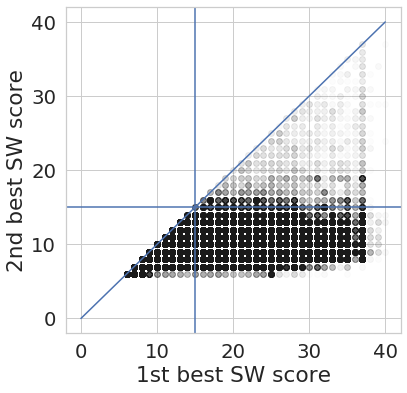

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(max_sw, second_best_sw, alpha=0.01, c="k")
ax.set_title("")
ax.set_xlabel("1st best SW score")
ax.set_ylabel("2nd best SW score")
ax.plot([0, 40], [0, 40])
ax.axhline(15)
ax.axvline(15)

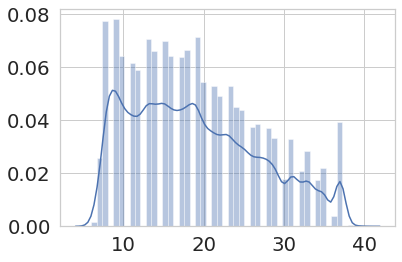

In [17]:
sns.distplot(max_sw)

### Merge & save alignment scores for all fq files

In [18]:
run_id = re.findall(r"runid_(.*)_[\d]+_[\d]+.tsv", sw_tsv)[0]

In [19]:
merged_sw_file = os.path.join(sw_dir, f"all_{run_id}.tsv")

In [20]:
sw.to_csv(merged_sw_file, sep="\t", index=True)

In [21]:
merged_sw_file

'/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/all_ad14db7fb43131fd3ac954214b0b4a3084956a53.tsv'

# Evaluate extant molbits vs rest

## Specify which molbits were actually present

In [22]:
# Create set_N variables based on spreadsheet
molbit_sets = {}
for ix, row in set_spreadsheet.iterrows():
    set_no = re.findall(r"set ([\d]+)", row["set"])[0]
    molbits = row["molbits_in_set"]
    molbit_sets[set_no] = molbits.replace(" ", "").split(",")

In [23]:
molbit_set_in_run = str(run_data.get("molbit_set"))
molbit_sets_on_flowcell = run_data.get("prev_on_flowcell")

molbits_in_run = molbit_sets[molbit_set_in_run]
molbits_on_flowcell = molbits_in_run[:]
if molbit_sets_on_flowcell != "none":
    molbit_sets_on_flowcell = molbit_sets_on_flowcell.split(", ")
    for m in molbit_sets_on_flowcell:
        print(m)
        print(molbit_sets[m])
        molbits_on_flowcell.extend(molbit_sets[m])
    print(molbits_on_flowcell)

## Extract the best-aligned molbit, across all 96 molbits

This cell replaces "make_sw_call" in the past. No more "-1"s. Just filter by accept_molbit.

In [24]:
sw_scores = sw.filter(regex="score_molbit_.*")
best_molbits = sw_scores.apply(np.argmax, axis=1)
accept_molbit = sw.lookup(sw.index, best_molbits) >= 15
sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/software/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


In [25]:
len(accept_molbit)

270028

In [26]:
sum(accept_molbit)

177297

In [27]:
sum(accept_molbit) / len(accept_molbit)

0.6565874650036293

## Extract the best-aligned molbit, across ONLY the extant molbits

In [28]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_on_flowcell]

In [29]:
extant_sw = sw.loc[:, extant_sw_cols]

In [30]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [31]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [32]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [33]:
n_extant_is_best

176827

Percentage of well-aligned reads that belong to the true set

In [34]:
n_extant_is_best/len(sw_accepted)

0.997349080920715

Read counts for each molbit

In [35]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('1', 823),
 ('12', 5773),
 ('15', 5059),
 ('17', 1294),
 ('19', 7257),
 ('22', 1268),
 ('23', 223),
 ('25', 2826),
 ('28', 925),
 ('29', 2533),
 ('32', 5362),
 ('35', 1236),
 ('37', 3718),
 ('38', 744),
 ('39', 2895),
 ('4', 927),
 ('40', 4179),
 ('43', 9235),
 ('45', 1861),
 ('46', 903),
 ('5', 5802),
 ('50', 6698),
 ('51', 4891),
 ('52', 1368),
 ('54', 5354),
 ('57', 2085),
 ('62', 1701),
 ('63', 5423),
 ('65', 2706),
 ('66', 1173),
 ('67', 1999),
 ('68', 3614),
 ('69', 1845),
 ('7', 2200),
 ('70', 1046),
 ('73', 3650),
 ('75', 3941),
 ('76', 212),
 ('78', 565),
 ('79', 735),
 ('80', 3044),
 ('81', 5721),
 ('83', 1192),
 ('85', 5945),
 ('86', 5420),
 ('87', 2722),
 ('88', 3843),
 ('89', 2987),
 ('9', 16634),
 ('90', 6476),
 ('92', 4321),
 ('93', 2943)]

In [36]:
print("\n".join([str(x) for x in c]))

823
5773
5059
1294
7257
1268
223
2826
925
2533
5362
1236
3718
744
2895
927
4179
9235
1861
903
5802
6698
4891
1368
5354
2085
1701
5423
2706
1173
1999
3614
1845
2200
1046
3650
3941
212
565
735
3044
5721
1192
5945
5420
2722
3843
2987
16634
6476
4321
2943


## Extract the best-aligned molbit, across ONLY the current run's molbits

In [37]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_in_run]

In [38]:
extant_sw = sw.loc[:, extant_sw_cols]

In [39]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [40]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [41]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [42]:
n_extant_is_best

176827

Percentage of well-aligned reads that belong to the true set

In [43]:
n_extant_is_best/len(sw_accepted)

0.997349080920715

Read counts for each molbit

In [44]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('1', 823),
 ('12', 5773),
 ('15', 5059),
 ('17', 1294),
 ('19', 7257),
 ('22', 1268),
 ('23', 223),
 ('25', 2826),
 ('28', 925),
 ('29', 2533),
 ('32', 5362),
 ('35', 1236),
 ('37', 3718),
 ('38', 744),
 ('39', 2895),
 ('4', 927),
 ('40', 4179),
 ('43', 9235),
 ('45', 1861),
 ('46', 903),
 ('5', 5802),
 ('50', 6698),
 ('51', 4891),
 ('52', 1368),
 ('54', 5354),
 ('57', 2085),
 ('62', 1701),
 ('63', 5423),
 ('65', 2706),
 ('66', 1173),
 ('67', 1999),
 ('68', 3614),
 ('69', 1845),
 ('7', 2200),
 ('70', 1046),
 ('73', 3650),
 ('75', 3941),
 ('76', 212),
 ('78', 565),
 ('79', 735),
 ('80', 3044),
 ('81', 5721),
 ('83', 1192),
 ('85', 5945),
 ('86', 5420),
 ('87', 2722),
 ('88', 3843),
 ('89', 2987),
 ('9', 16634),
 ('90', 6476),
 ('92', 4321),
 ('93', 2943)]

In [45]:
l = []
for i in range(0, 96, 16):
    l.extend(range(i, i+8))

In [46]:
", ".join([str(x) for x in l])

'0, 1, 2, 3, 4, 5, 6, 7, 16, 17, 18, 19, 20, 21, 22, 23, 32, 33, 34, 35, 36, 37, 38, 39, 48, 49, 50, 51, 52, 53, 54, 55, 64, 65, 66, 67, 68, 69, 70, 71, 80, 81, 82, 83, 84, 85, 86, 87'

## Get counts for all molbits

In [47]:
m, c = np.unique(sw[sw["accept_molbit"]]["best_molbit"], return_counts=True)
molbit_counts = dict(zip(m, c))
for i in range(96):
    i = str(i)
    if i in molbit_counts:
        print(f"{molbit_counts[i]}")
    else:
        print(f"0")

1
823
1
0
927
5798
0
2189
9
16606
0
2
5772
24
0
5055
7
1282
0
7256
0
0
1268
223
0
2825
0
7
925
2533
2
0
5362
0
2
1226
29
3655
744
2893
4179
1
1
9228
0
1861
878
14
1
127
6697
4890
1366
25
5349
29
1
2085
80
0
0
5
1691
5423
1
2704
1173
1995
3606
1837
1046
0
0
3649
7
3824
196
1
564
696
3044
5721
65
1192
0
5937
5420
2700
3843
2987
6473
24
4268
2943
1
3


# Plot read counts

In [48]:
def plot_read_counts(labels, counts, labels_on_flowcell, labels_in_run,
                     possible_labels=None, ax=None, vmax=None, title_note=None):
    from matplotlib.patches import Patch
    if vmax is None:
        vmax = max(counts) + max(counts)
    if ax == None:
        fig, ax = plt.subplots(figsize=(30, 8))
    if possible_labels is None:
        possible_labels = labels[:]
    g = sns.barplot(x=labels, y=counts, order=possible_labels, ax=ax)
    title = "#/reads identified per barcode"
    if title_note is not None:
        title += "\n(%s)" % title_note
    ax.set_title(title)
    ax.set_xlabel("Barcode ID")
    ax.set_ylabel("Read counts")
    ax.set_ylim([0, vmax])
    
    prev_text_height = 0
    for j, label in enumerate(possible_labels):
        if label in labels:
            count = counts[labels.index(label)]
        else:
            count = 0
        if label == "-1":
            continue

#         try:
#             label = int(label)
#         except:
#             pass
        
        if label in labels_in_run:
            g.containers[0].get_children()[j].set_facecolor("tab:red")
            font_kwargs = {"color": "tab:red", "weight": "bold"} 
        elif label in labels_on_flowcell:
            g.containers[0].get_children()[j].set_facecolor("tab:blue")
            font_kwargs = {"color": "k", "weight": "bold"}
        else:
            g.containers[0].get_children()[j].set_facecolor("k")
            font_kwargs = {"color": "k", "weight": "normal"}
            
        diff = prev_text_height - (count + 0.01 * vmax)
        if count < 100:
            text_height = count + .01 * vmax
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        elif diff < 0 and np.abs(diff) < vmax * .06:
            text_height = np.max([prev_text_height + .035 * vmax, count + .01 * vmax])
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        elif np.abs(diff) < vmax * .05:
            text_height = np.min([prev_text_height - .01 * vmax, count + .01 * vmax])
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        else:
            text_height = count + .01 * vmax
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        prev_text_height = text_height
        
    legend_elements = [Patch(facecolor='k', edgecolor='k',
                         label='never been run on this flowcell'),
                       Patch(facecolor='tab:blue', edgecolor='tab:blue',
                         label='prev run on flowcell'),
                       Patch(facecolor='tab:red', edgecolor='tab:red',
                         label='current run on flowcell')]
    leg = ax.legend(handles=legend_elements)
    t1, t2, t3 = leg.get_texts()
    t2._fontproperties = t1._fontproperties.copy()
    t3._fontproperties = t1._fontproperties.copy()
    t2.set_weight('bold')
    t3.set_weight('bold')
    t3.set_color("tab:red")
    return ax

[16:59:52 - matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 3.335
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
[16:59:52 - matplotlib.fo

[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-ExtraLight.otf) normal normal light normal>) = 10.24
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Meera' (Meera.ttf) normal normal 400 normal>) = 10.05
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Lohit Gujarati' (Lohit-Gujarati.ttf) normal normal 400 normal>) = 10.05
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS75F.ttf) normal normal bold normal>) = 10.335
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'PakType Naqsh' (PakType_Naqsh.ttf) normal normal 400 normal>) = 10.05
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'FreeMono' (FreeMonoBold.ttf) normal normal bold normal>) = 10.335
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-Medium.otf) normal normal medium normal>) = 10.145
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Bol

[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Lohit Assamese' (Lohit-Assamese.ttf) normal normal 400 normal>) = 10.05
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'VL Gothic' (VL-Gothic-Regular.ttf) normal normal regular normal>) = 10.05
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Noto Sans Lisu' (NotoSansLisu-Regular.ttf) normal normal 400 normal>) = 10.05
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Regular.ttf) normal normal 400 normal>) = 10.05
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal light normal>) = 2.24
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Waree' (Waree-BoldOblique.ttf) oblique normal bold normal>) = 11.335
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'STIX' (STIX-Regular.otf) normal normal regular normal>) = 10.05
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Lohit Oriya' (Lohit-

[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'PT Sans Narrow' (PTN57F.ttf) normal normal 400 condensed>) = 10.535
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-Light.otf) normal normal light normal>) = 10.525
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Khmer OS Content' (KhmerOS_content.ttf) normal normal 400 normal>) = 10.335
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS76F.ttf) italic normal bold normal>) = 11.0
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS56F.ttf) italic normal 400 normal>) = 11.335
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Caladea' (Caladea-Italic.ttf) italic normal 400 normal>) = 11.335
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Cantarell' (Cantarell-BoldOblique.otf) oblique normal bold normal>) = 11.0
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans TWHK' (SourceHanSa

[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal bold normal>) = 4.0
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans TWHK' (SourceHanSansTWHK-Light.otf) normal normal light normal>) = 10.525
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal bold normal>) = 11.0
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Cantarell' (Cantarell-Bold.otf) normal normal bold normal>) = 10.0
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 4.335
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'NanumGothic' (NanumGothicExtraBold.ttf) normal normal bold normal>) = 10.0
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans TWHK' (SourceHanSansTWHK-Regular.otf) normal normal regular normal>) = 10.335
[16:59:52 - 

[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.335
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal bold normal>) = 11.0
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.335
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.335
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal bold normal>) = 11.0
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal bold normal>) = 2.0
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.335
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal

[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'FreeSans' (FreeSansBoldOblique.ttf) oblique normal bold normal>) = 11.0
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'FreeMono' (FreeMono.ttf) normal normal 400 normal>) = 10.335
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Noto Sans Tagalog' (NotoSansTagalog-Regular.ttf) normal normal 400 normal>) = 10.335
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Lohit Tamil' (Lohit-Tamil.ttf) normal normal 400 normal>) = 10.335
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Italic.ttf) italic normal 400 condensed>) = 11.535
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Caladea' (Caladea-BoldItalic.ttf) italic normal bold normal>) = 11.0
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-Normal.otf) normal normal normal normal>) = 10.335
[16:59:52 - matplotlib.font_manager] findfont: scor

[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS55F.ttf) normal normal 400 normal>) = 10.335
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Padauk' (Padauk-bold.ttf) normal normal bold normal>) = 10.0
[16:59:52 - matplotlib.font_manager] findfont: score(<Font 'Lohit Kannada' (Lohit-Kannada.ttf) normal normal 400 normal>) = 10.335
[16:59:52 - matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=bold:stretch=normal:size=19.8 to DejaVu Sans ('/ssd1/home/kdorosch/software/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf') with score of 2.000000.


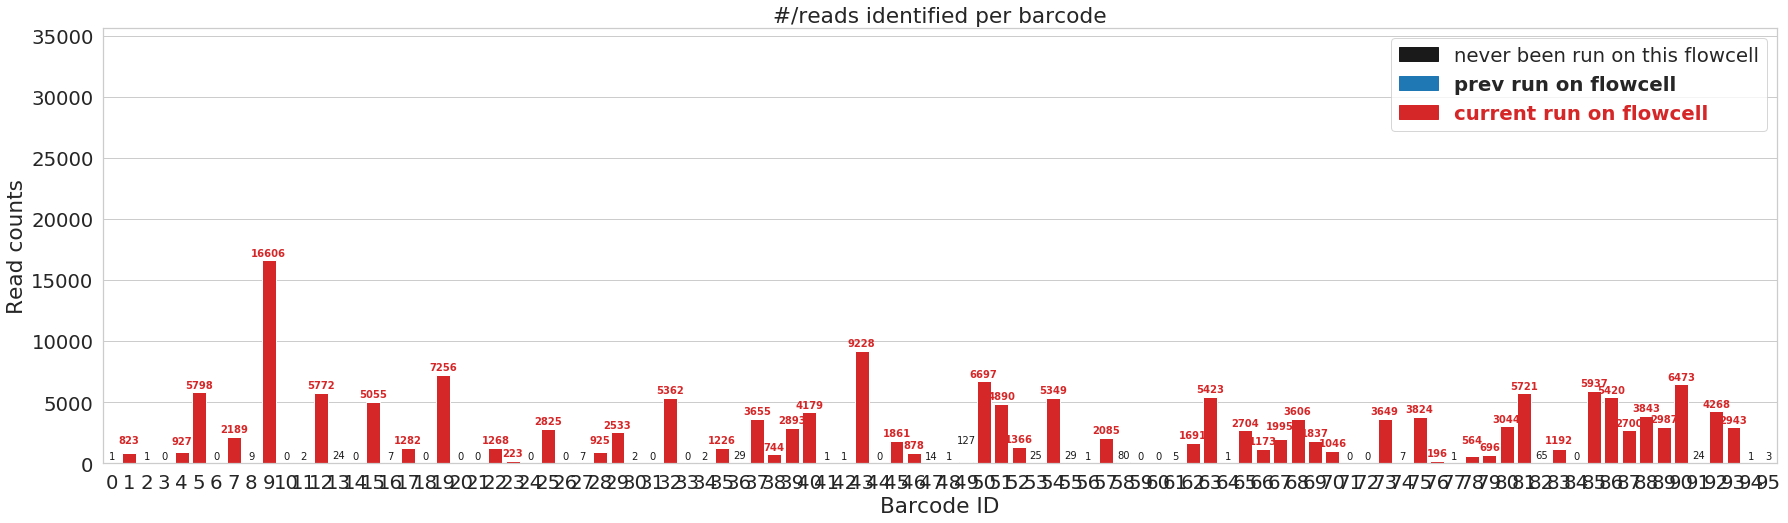

In [49]:
molbits = [str(x) for x in m]
counts = list(c)
on_flowcell = [str(x) for x in molbits_on_flowcell]
in_run = [str(x) for x in molbits_in_run]
poss_molbits = [str(x) for x in range(96)]
plot_read_counts(molbits, counts, on_flowcell, in_run, possible_labels=poss_molbits, vmax=35600)

# Save labels

In [50]:
merged_sw_file

'/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/all_ad14db7fb43131fd3ac954214b0b4a3084956a53.tsv'

In [51]:
sw = pd.read_csv(merged_sw_file, sep="\t", index_col=0)
sw_scores = sw.filter(regex="score_molbit_.*")
best_molbits = sw_scores.apply(np.argmax, axis=1)
accept_molbit = sw.lookup(sw.index, best_molbits) >= 15
sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
sw["accept_molbit"] = accept_molbit
sw["best_molbit_is_in_run"] = sw["best_molbit"].apply(lambda x: x in molbits_in_run)

labels_in_set = sw[np.logical_and(sw["accept_molbit"], sw["best_molbit_is_in_run"])]

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """


In [52]:
sw_label_file = merged_sw_file.replace("all", "labels_for_molbits_in_set")
print(sw_label_file)

/path/to/data/MinION_sequencing_data_20191011/guppy_3.2.2_10_11_19_run_02_exec_20191014/sw/labels_for_molbits_in_set_ad14db7fb43131fd3ac954214b0b4a3084956a53.tsv


In [53]:
best_score = np.max(labels_in_set[[f"sw_score_molbit_{molbit}" for molbit in molbits_in_run]], axis=1)
labels_in_set["best_score"] = best_score
labels_in_set = labels_in_set.loc[:, ["best_molbit", "best_score"]]
labels_in_set.columns = ["molbit", "sw_score"]

labels_in_set.to_csv(sw_label_file, sep="\t", index=True)

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
